This tutorial focuses on the task of image segmentation, using a modified U-Net.

- Where object is located in
- Shape of that object
- Which pixel belongs to which object

In this case, we segment the image, i.e., each pixel of the image is given a label.

Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i,e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the Oxford-IIIT Pet Dataset, created by Parkhi et al. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :
- Class 1 : Pixel belonging to the pet.
- Class 2 : Pixel bordering the pet.
- Class 3 : None of the above/ Surrounding pixel.

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
# Download the Oxford-IIIT Pets dataset
dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteXWIK9I/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteXWIK9I/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0. Subsequent calls will reuse this data.


The following code performs a single augmentation of flipping an image. In addition, image is normalized to [0, 1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convinience, let's subtract 1 from the segmentation mask, resulting in labels that are: {0, 1, 2}

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
# The dataset already contains the required splits of test and train
# and so let's continue to use the same split.
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.0.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    urls=['http://www.robots.ox.ac.uk/~vgg/data/pets/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Jawahar, C.~V.",
      title        = "Cats and Dogs",
      booktitle    =

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [11]:
print(dataset)

{'test': <_OptionsDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1)}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8}>, 'train': <_OptionsDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1)}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8}>}


In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's corresponding mask from the dataset.

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i + 1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

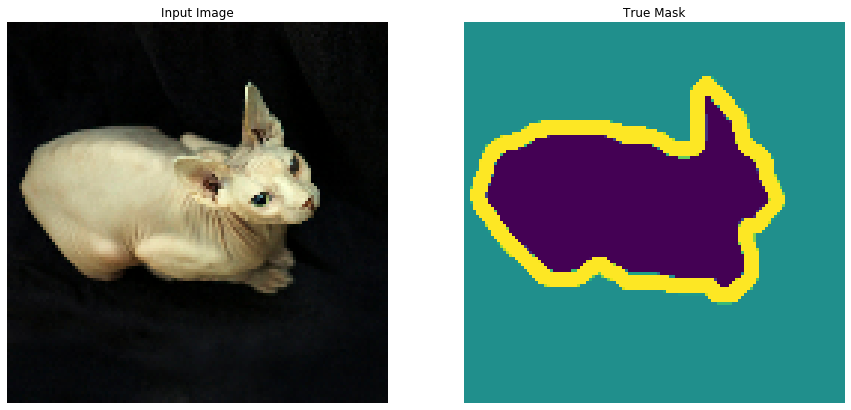

In [20]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Define model
The model being used here is a modified U-Net. A U-Net consists of an encoder(downsampler) and decoder(upsampler). In order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block alread implemented in TensorFlow example in the pix2pix tutorial.

In [0]:
# The reason to output three channels is because there are three possible labels
# for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.
OUTPUT_CHANNELS = 3

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], 
                                               include_top=False)

# Use the activations of these layers.
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project',     # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

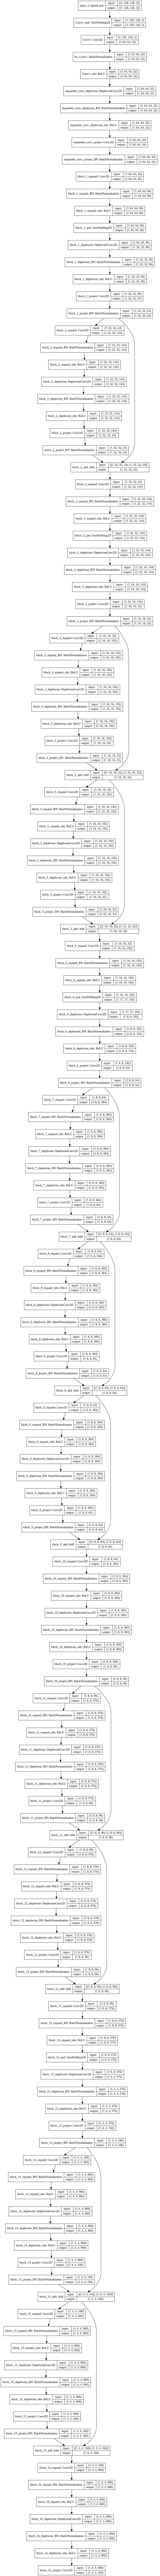

In [24]:
# Outputs을 Intermediate layer 여러개 해야할 것 같은데 하나만 나오는것 같네.
tf.keras.utils.plot_model(down_stack, show_shapes=True)

In [25]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [31]:
outputs = down_stack(tf.random.normal((1, 128, 128, 3)))
for output in outputs:
  print(output.shape)
# 모델은 하나인데 output만 쪽 꺼내서 쓰는건가부다.

(1, 64, 64, 96)
(1, 32, 32, 144)
(1, 16, 16, 192)
(1, 8, 8, 576)
(1, 4, 4, 320)


The decoder/upsampler is simply a series of upsample blocks.

In [0]:
up_stack = [
    pix2pix.upsample(512, 3), # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3), # 16x16 -> 32x32
    pix2pix.upsample(64, 3),  # 32x32 -> 64x64
]
# 여기에서 이 숫자들이 어떻게 정해진건지 pix2pix 코드를 보자.

In [0]:
def unet_model(output_channels):
  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax') # 64x64 -> 128x128
  
  inputs = tf.keras.layers.Input(shape=(128, 128, 3))
  x = inputs

  # Downsamling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connectinos
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is losses.sparse_categorical_crossentropy. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and losses.sparse_categorical_crossentropy is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

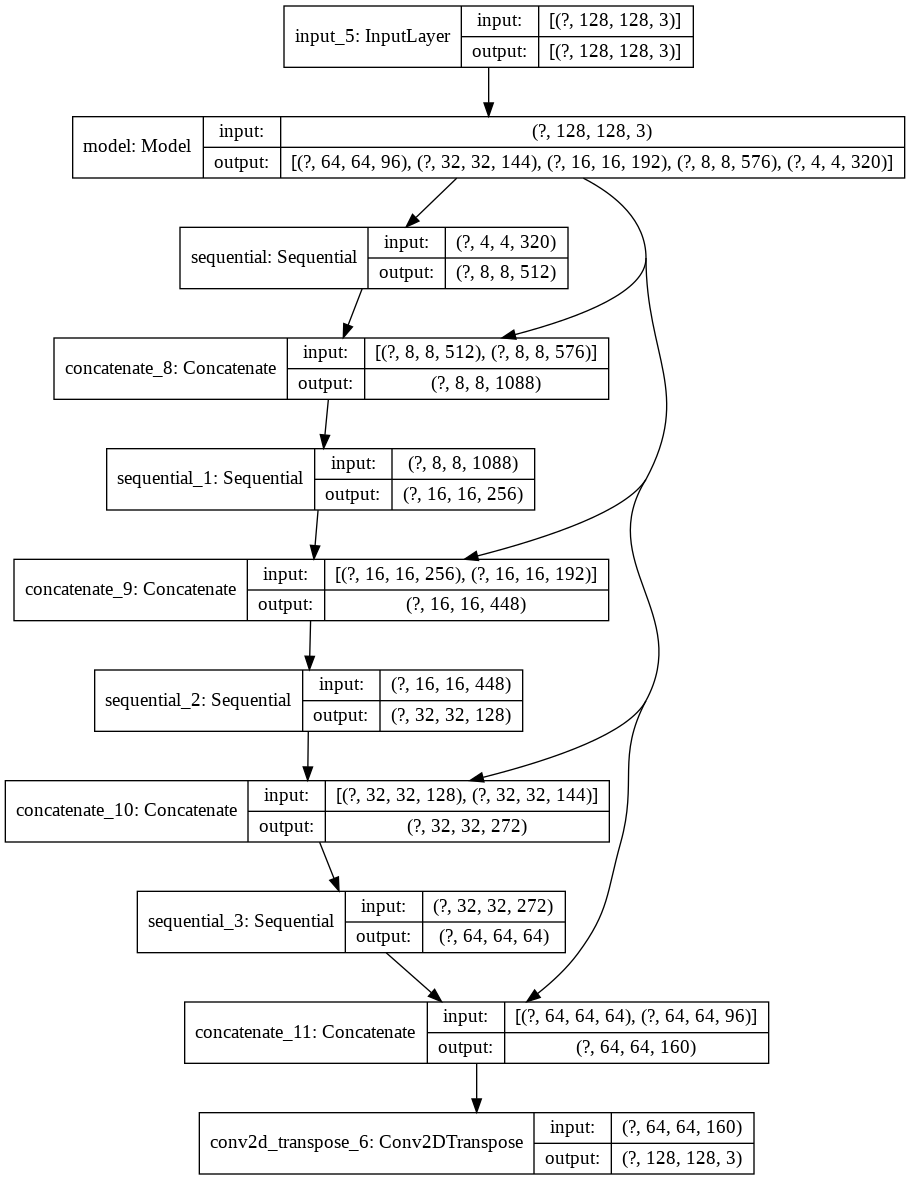

In [39]:
# Have a quick look at the resulting model architecture:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what is predicts before training.

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1) # (batch, im, im, 3)
  pred_mask = pred_mask[..., tf.newaxis] # (img_size, img_size, 1)
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

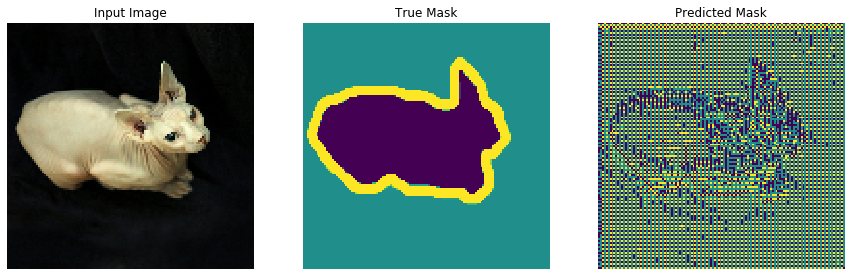

In [64]:
show_predictions()

In [0]:
# Observe how the model improves while it is training.
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample prediction after epoch {}\n'.format(epoch + 1))

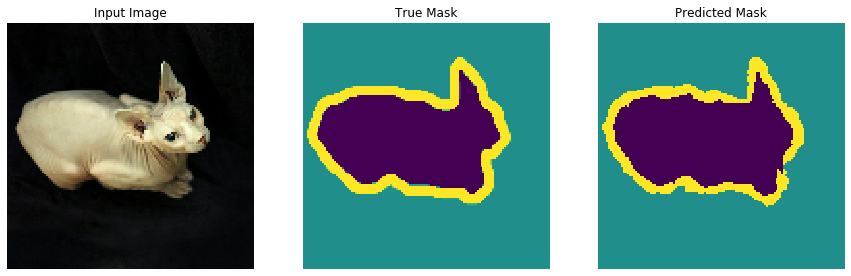


Sample prediction after epoch 20

57/57 [==============================] - 18s 315ms/step - loss: 0.1443 - accuracy: 0.9345 - val_loss: 0.3361 - val_accuracy: 0.8804


In [67]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

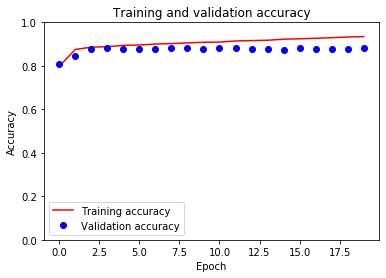

In [69]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

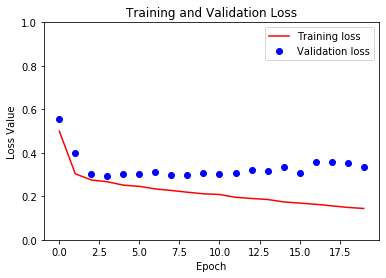

In [70]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

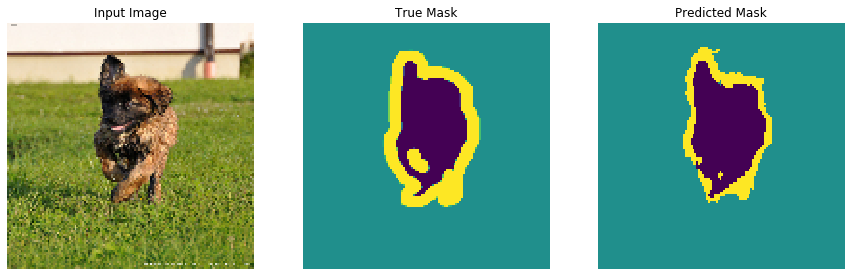

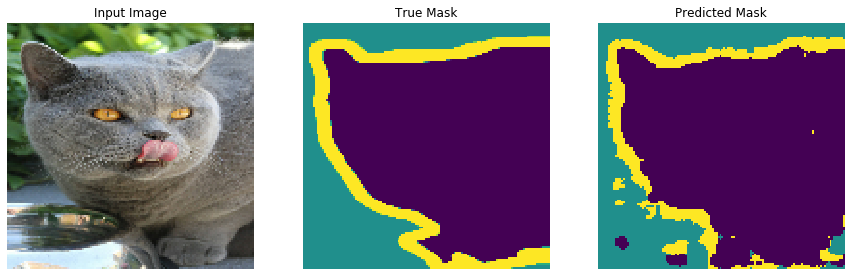

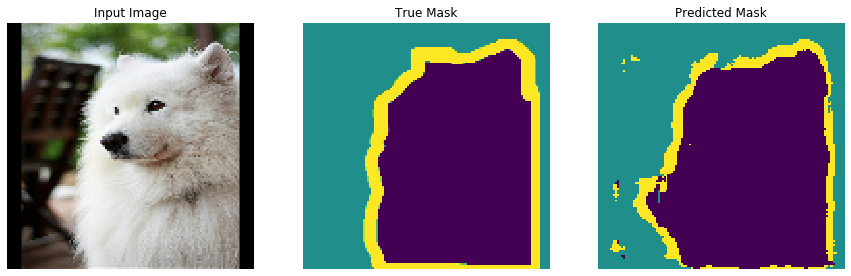

In [72]:
show_predictions(test_dataset, 3)